Importing Required Libraries

In [10]:
import cv2
from ultralytics import YOLO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


Load YOLOv8 pre-trained model, because v5 is not detecting flags

In [11]:
yolo_model = YOLO('yolov8n.pt')  # Load the model
yolo_model.to('cpu') # set to cpu

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

Locate Flag Region Using YOLOv8 (Image Segmentation)

In [12]:
def locate_flag_region_with_yolo(image_path):
    # Use YOLOv8 to detect objects in the image
    results = yolo_model.predict(source=image_path, conf=0.25)
    detections = results[0].boxes.xyxy.numpy()  # Get bounding boxes (x_min, y_min, x_max, y_max)

    if len(detections) == 0:
        return None, None  # No flag detected
    largest_box = max(detections, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]))

    x_min, y_min, x_max, y_max = map(int, largest_box)
    image = Image.open(image_path)
    flag_region = image.crop((x_min, y_min, x_max, y_max))
    return flag_region, (x_min, x_max, y_min, y_max)

### This time I have tried distinguishing flag using sobel based bounday making, aspect ratio and image division into two

Indentify flag with Sobel

In [13]:
def identify_flag_with_sobel(image_path):
    flag_region, region_coords = locate_flag_region_with_yolo(image_path)
    if flag_region is None:
        return "No flag detected", None

    # Resize the flag region
    resized_flag = flag_region.resize((100, 60))
    flag_array = np.array(resized_flag.convert("L"))  # Convert to grayscale

    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(flag_array, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(flag_array, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Calculate edge strength for top and bottom halves
    height = flag_array.shape[0]
    top_half = sobel_magnitude[:height // 2, :]
    bottom_half = sobel_magnitude[height // 2:, :]
    top_strength = np.sum(top_half)
    bottom_strength = np.sum(bottom_half)

    # Determine flag based on edge strength
    if top_strength > bottom_strength:  # Top has more edges (red for Indonesia)
        return "Indonesia", region_coords
    elif bottom_strength > top_strength:  # Bottom has more edges (red for Poland)
        return "Poland", region_coords
    else:
        return "Unknown flag", region_coords

Locating and Identifing Flag using Aspect Ratio

In [14]:
def locate_flag_with_aspect_ratio(image_path):
    flag_region, region_coords = locate_flag_region_with_yolo(image_path)
    if flag_region is None:
        return None, "No flag detected"

    # Maintain 2:3 aspect ratio (height = 2/3 * width)
    width, height = flag_region.size
    target_height = int((2 / 3) * width)
    
    if height > target_height:  # Crop the height if needed
        flag_region = flag_region.crop((0, 0, width, target_height))
    
    return flag_region, region_coords

def identify_flag_with_aspect_ratio(image_path):
    flag_region, region_coords = locate_flag_with_aspect_ratio(image_path)
    if flag_region is None:
        return "No flag detected", None

    # Resize to a standard size
    resized_flag = flag_region.resize((100, 60))
    flag_array = np.array(resized_flag)

    # Perform color analysis
    height = resized_flag.height
    top_half = flag_array[:height // 2, :, :]
    bottom_half = flag_array[height // 2:, :, :]

    # Calculate mean red intensity for top and bottom halves
    top_red_mean = np.mean(top_half[:, :, 0])
    bottom_red_mean = np.mean(bottom_half[:, :, 0])

    if top_red_mean > bottom_red_mean:
        return "Indonesia", region_coords
    elif bottom_red_mean > top_red_mean:
        return "Poland", region_coords
    else:
        return "Unknown flag", region_coords


Identify by dividing into Two

In [24]:
def identify_flag(image_path):
    # Step 1: Locate the flag region with YOLOv8
    flag_region, region_coords = locate_flag_region_with_yolo(image_path)
    if flag_region is None:
        return "No flag region detected", None
    
    # Step 2: Resize the flag region to a standard size
    resized_flag = flag_region.resize((100, 60))
    
    # Step 3: Convert the flag to an RGB array
    rgb_flag = np.array(resized_flag)
    
    # Step 4: Split into top and bottom halves
    height = rgb_flag.shape[0]
    top_half = rgb_flag[:height // 2, :, :]
    bottom_half = rgb_flag[height // 2:, :, :]
    
    # Step 5: Calculate mean red intensity of each half
    top_red_mean = np.mean(top_half[:, :, 0])  # Red channel of top half
    bottom_red_mean = np.mean(bottom_half[:, :, 0])  # Red channel of bottom half
    
    # Step 6: Determine flag based on red intensity comparison
    if top_red_mean > bottom_red_mean:  # Top is red, bottom is white
        return "Indonesia", region_coords
    elif bottom_red_mean > top_red_mean:  # Top is white, bottom is red
        return "Poland", region_coords
    else:
        return "Unknown flag", region_coords


Showing Image in Grid

In [25]:
def show_images_in_grid(image_paths):
    num_images = len(image_paths)
    
    # Create a grid for displaying images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i, image_path in enumerate(image_paths):
        result, region_coords = identify_flag(image_path) # Change this line to use a different methods
        
        # Display the image with detected region
        image = Image.open(image_path)
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{result}")
        
        if region_coords:
            x_min, x_max, y_min, y_max = region_coords
            axes[i, 0].add_patch(
                plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                              linewidth=2, edgecolor='red', facecolor='none')
            )
        
        # Show the cropped region (flag region) on the right side
        flag_region, _ = locate_flag_region_with_yolo(image_path)
        if flag_region is not None:
            axes[i, 1].imshow(flag_region, cmap='gray')
            axes[i, 1].axis('off')
            axes[i, 1].set_title("Flag Region")
    
    plt.tight_layout()
    plt.show()

Test with a list of image paths


image 1/1 c:\Users\vaibh\PycharmProjects\231115_Vaibhav Itauriya_deeploycv\Assignment 2\poland1.jpg: 416x640 1 kite, 155.1ms
Speed: 3.5ms preprocess, 155.1ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 c:\Users\vaibh\PycharmProjects\231115_Vaibhav Itauriya_deeploycv\Assignment 2\poland1.jpg: 416x640 1 kite, 153.7ms
Speed: 3.1ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 c:\Users\vaibh\PycharmProjects\231115_Vaibhav Itauriya_deeploycv\Assignment 2\poland2.jpg: 416x640 (no detections), 186.2ms
Speed: 3.7ms preprocess, 186.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 c:\Users\vaibh\PycharmProjects\231115_Vaibhav Itauriya_deeploycv\Assignment 2\poland2.jpg: 416x640 (no detections), 210.5ms
Speed: 3.6ms preprocess, 210.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 c:\Users\vaibh\PycharmProjects\231115_Vaibhav Itauriya_deeploycv\Assignment

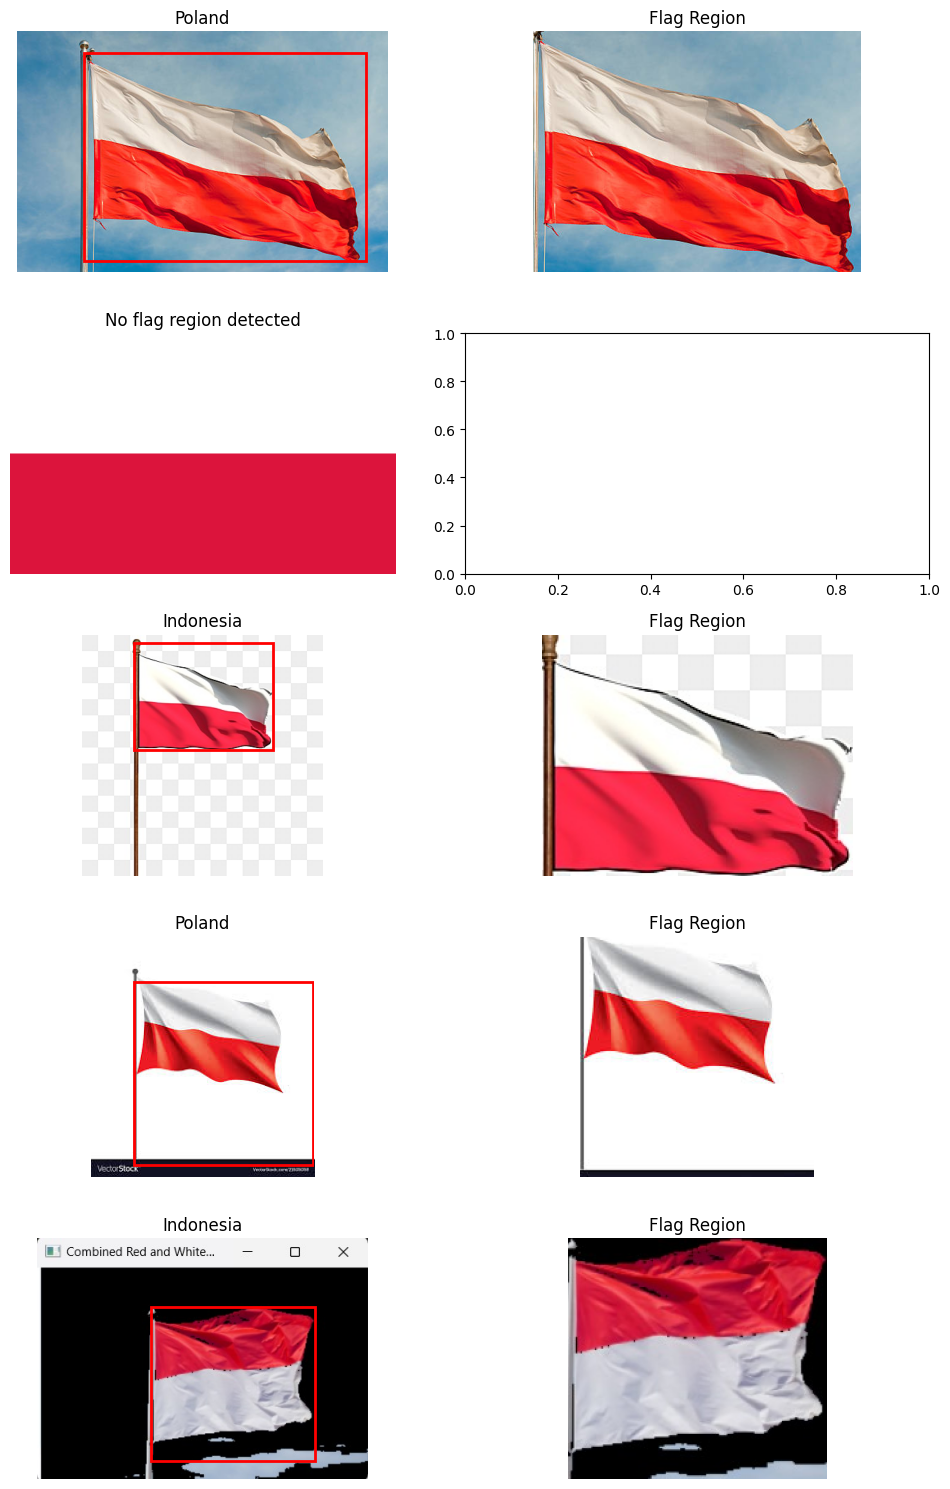

In [26]:
image_paths = [f"poland{i}.jpg" for i in range(1, 6)]  # Replace with actual image paths
show_images_in_grid(image_paths)
